# MCA Signal Extraction
---

In [1]:
%%time
import glob, datetime, warnings, utm, mcaap, sys
sys.path.append('/Users/mronacgiannone/Documents/Cardinal')
import cardinal
#-----------------------------------------------------------------------------------------------------------------#
# Command to make all plots interactive
%matplotlib ipympl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from obspy import *
from obspy.core import *
from scipy import signal
from pyproj import Geod; g = Geod(ellps='sphere')

warnings.filterwarnings('ignore')

# Global variables where data are stored
MCA_dir = '/Volumes/Extreme SSD/McAAP/Winter_2021/'

CPU times: user 3.52 s, sys: 4.01 s, total: 7.53 s
Wall time: 4.22 s


## Plotting MCA Data for Each Day
---
#### Need to determine days in which observations were made

<IPython.core.display.Javascript object>


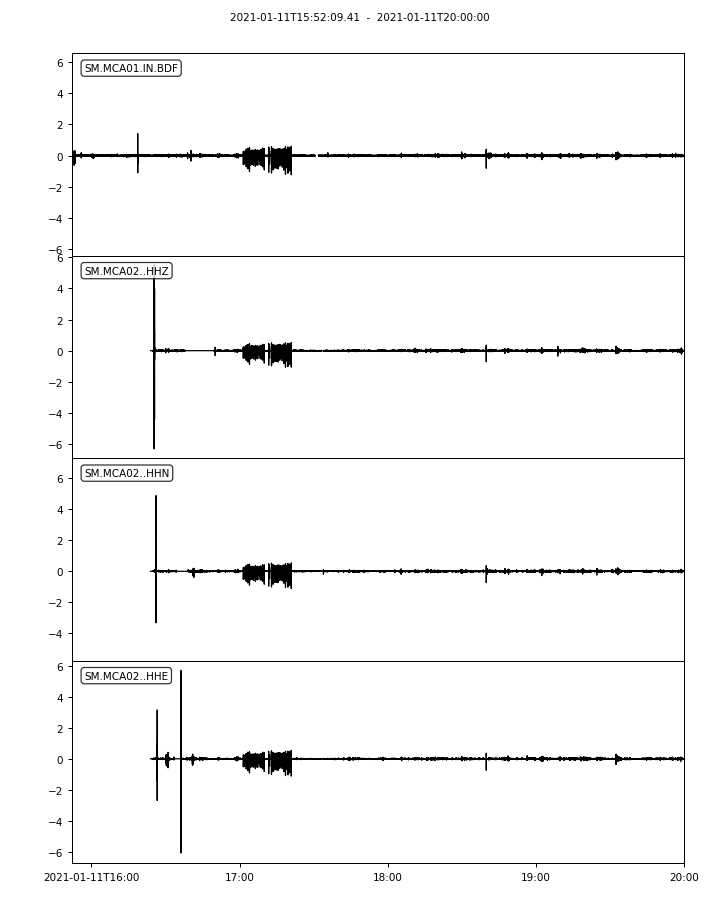

<IPython.core.display.Javascript object>


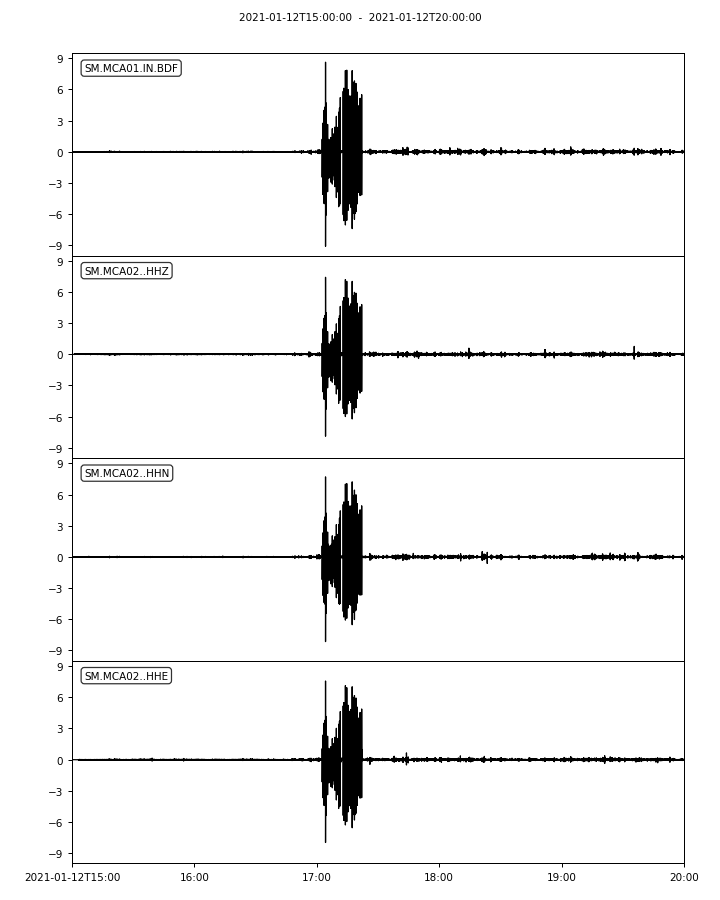

<IPython.core.display.Javascript object>


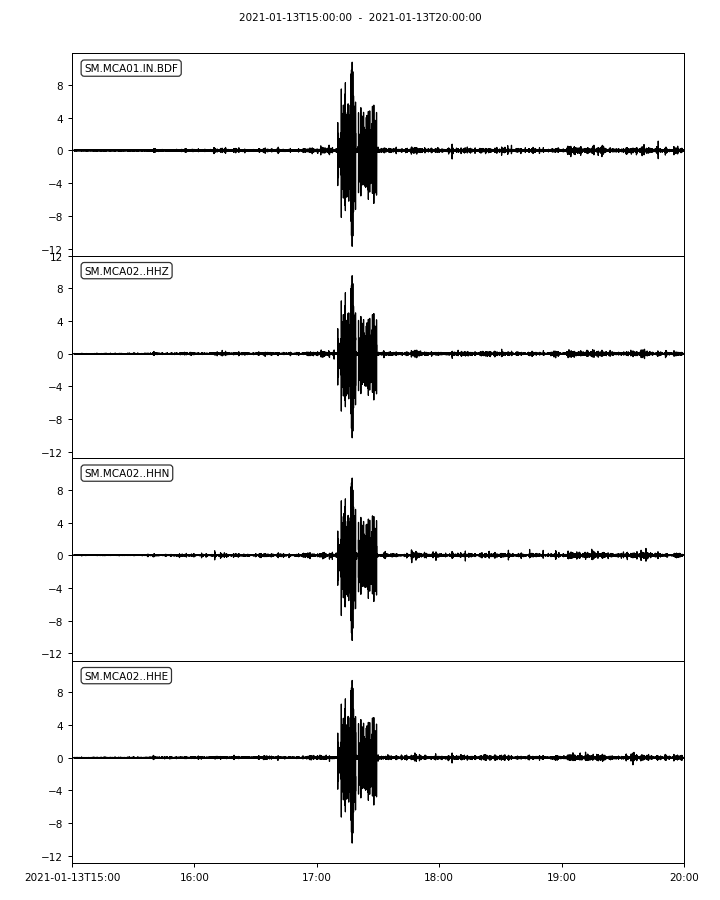

<IPython.core.display.Javascript object>


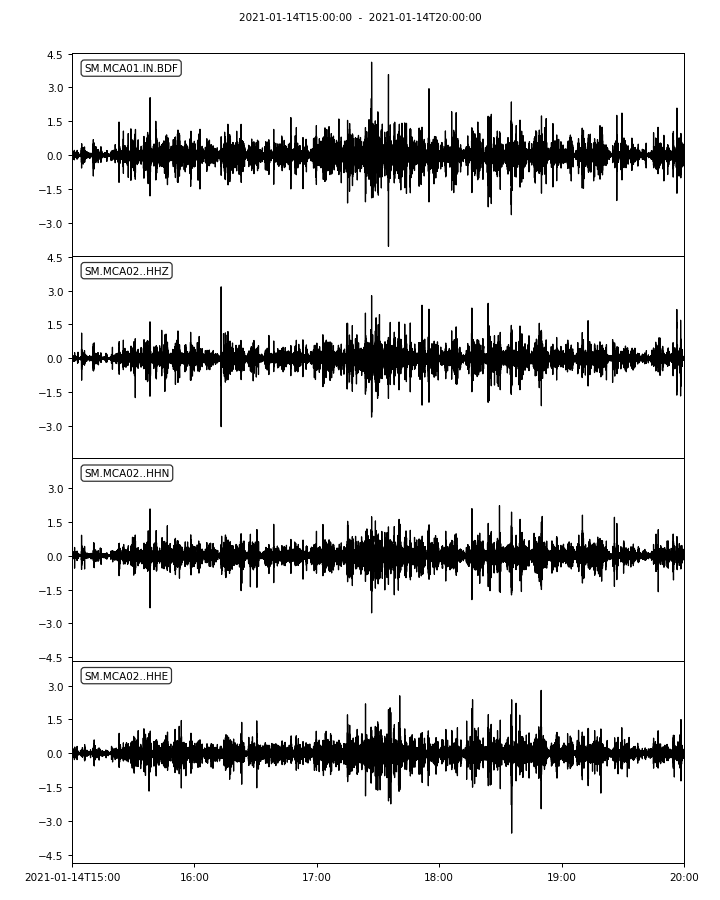

<IPython.core.display.Javascript object>


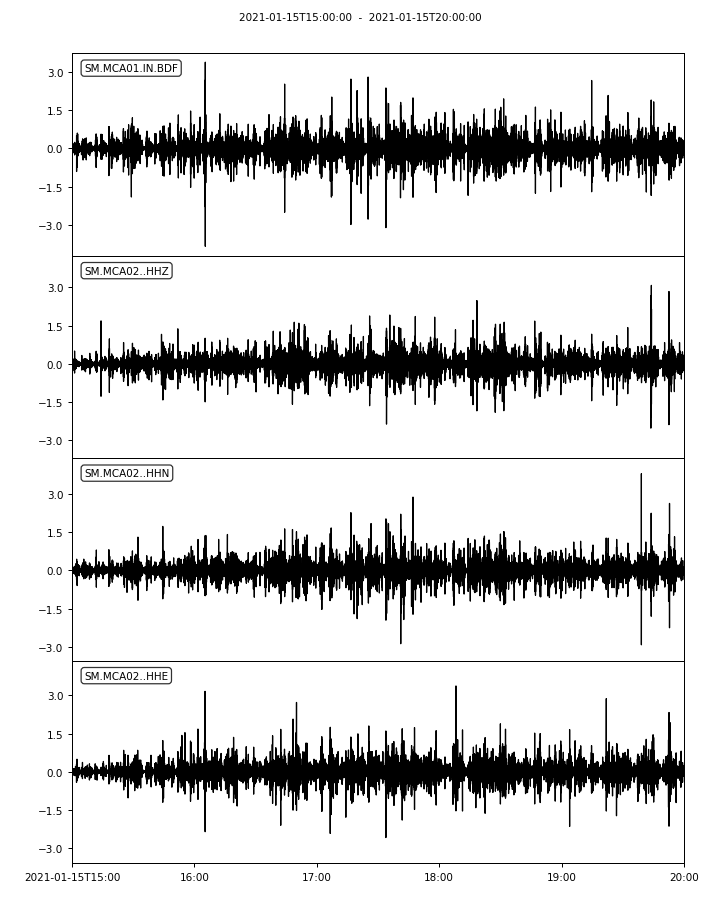

<IPython.core.display.Javascript object>


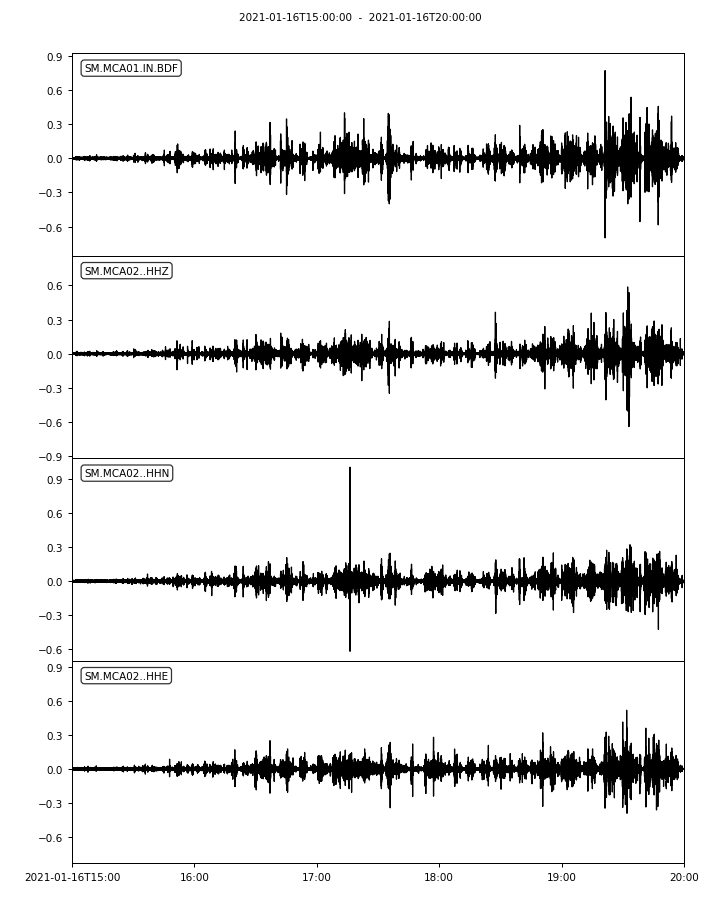

<IPython.core.display.Javascript object>


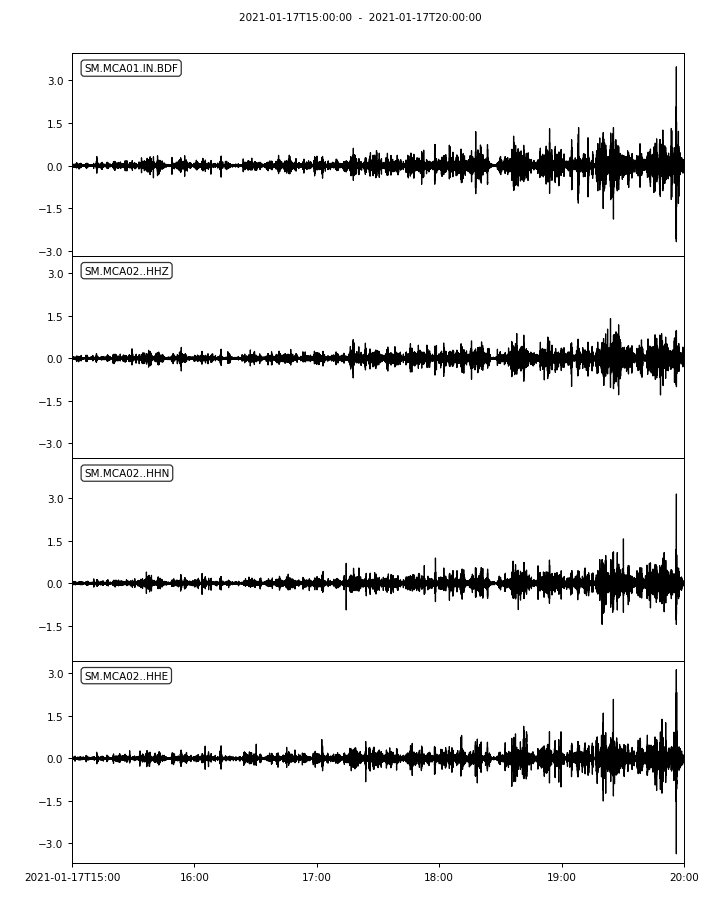

<IPython.core.display.Javascript object>


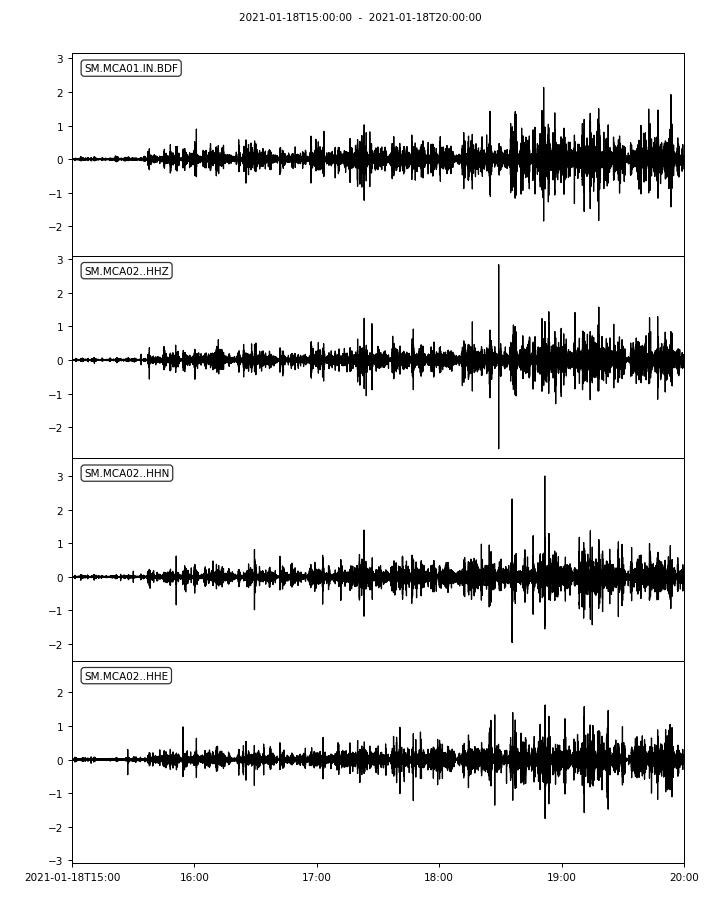

<IPython.core.display.Javascript object>


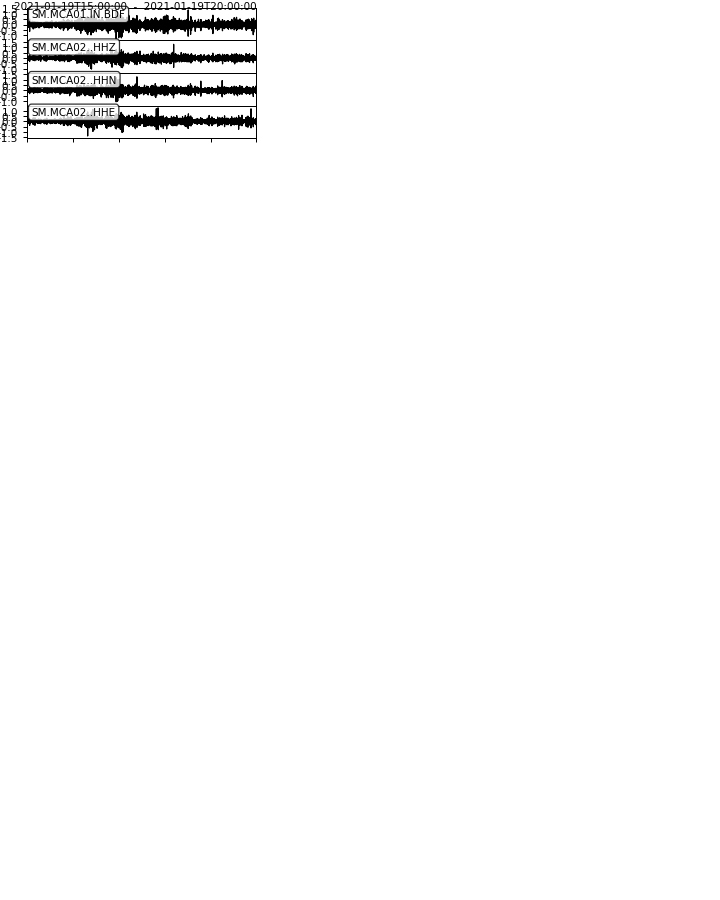

<IPython.core.display.Javascript object>


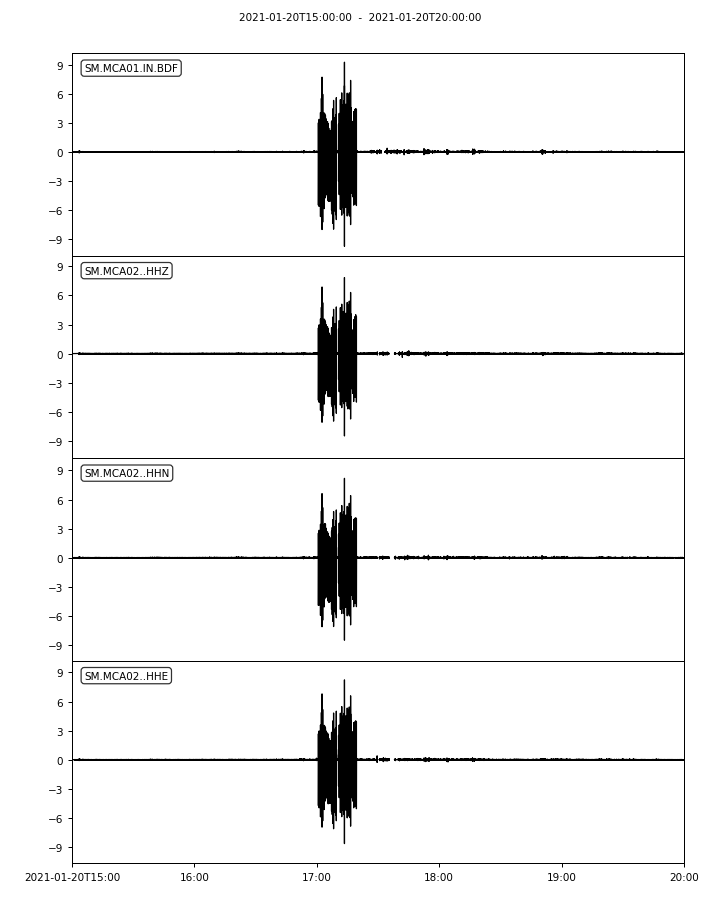

<IPython.core.display.Javascript object>


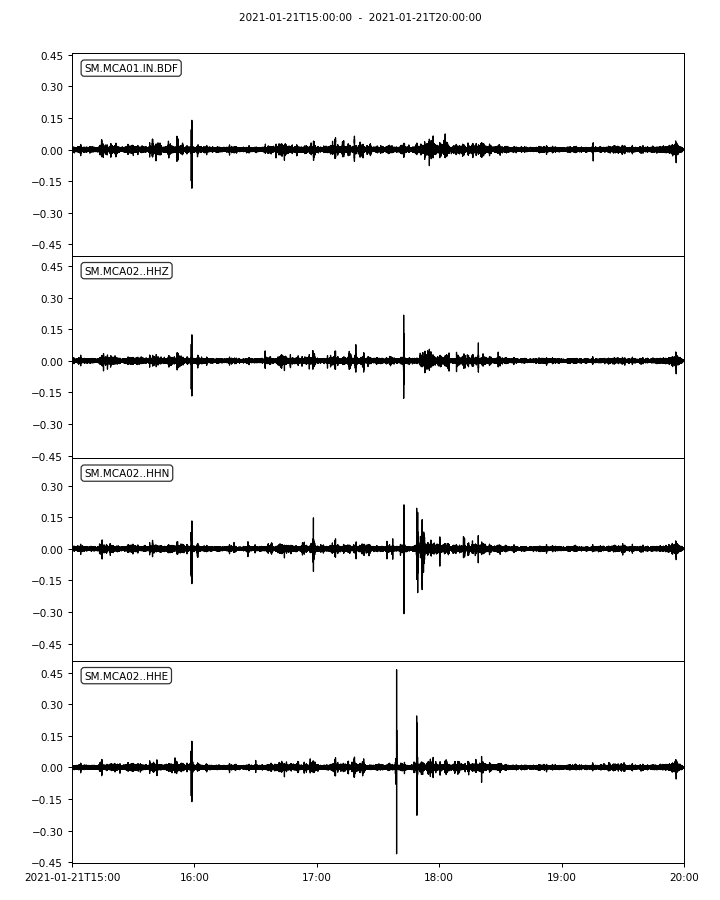

<IPython.core.display.Javascript object>


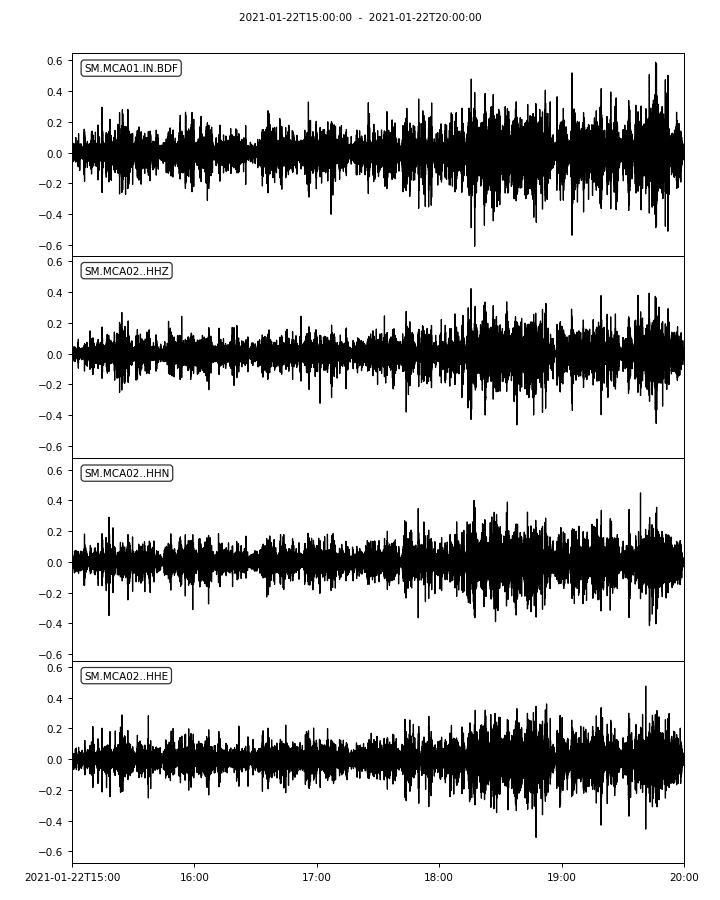

<IPython.core.display.Javascript object>


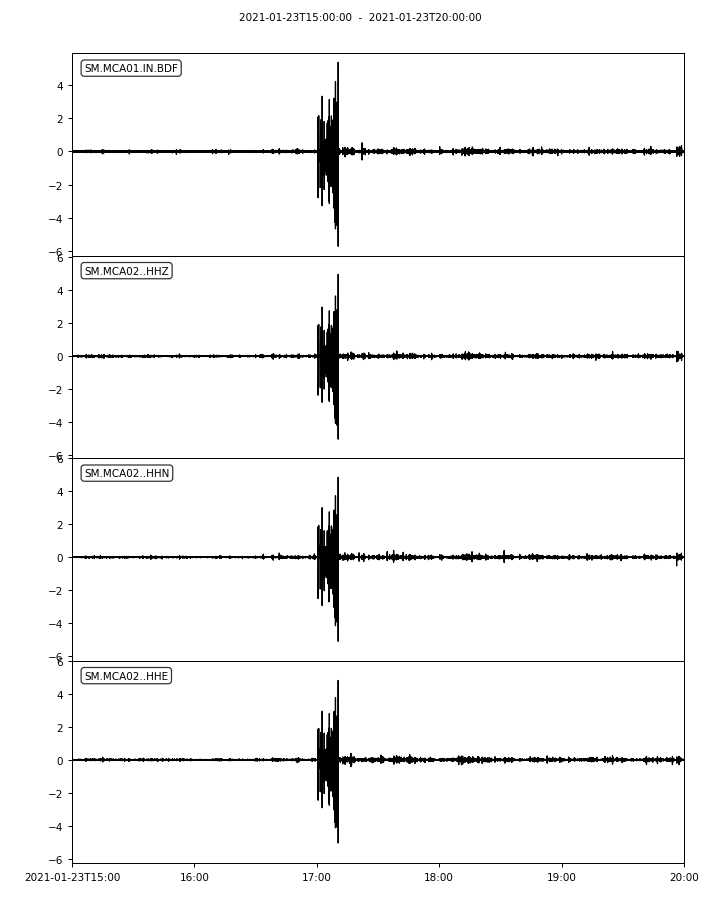

<IPython.core.display.Javascript object>


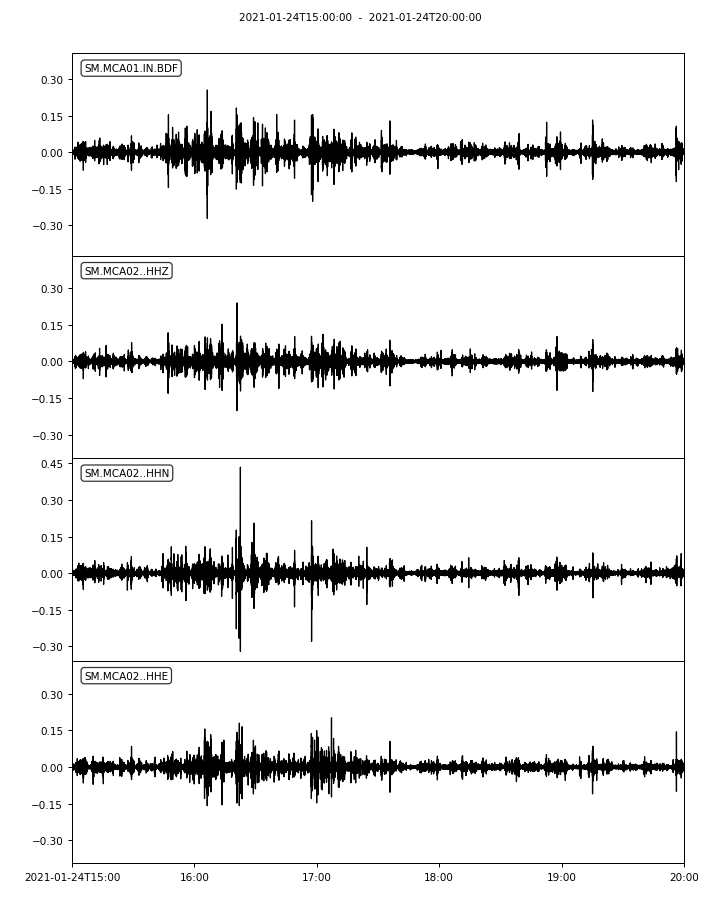

<IPython.core.display.Javascript object>


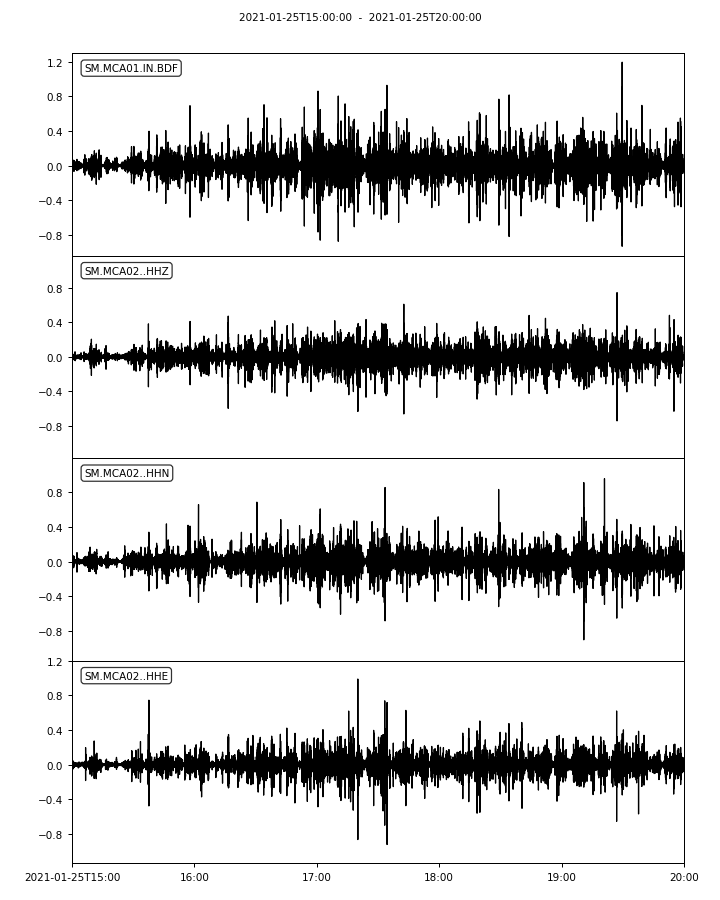

<IPython.core.display.Javascript object>


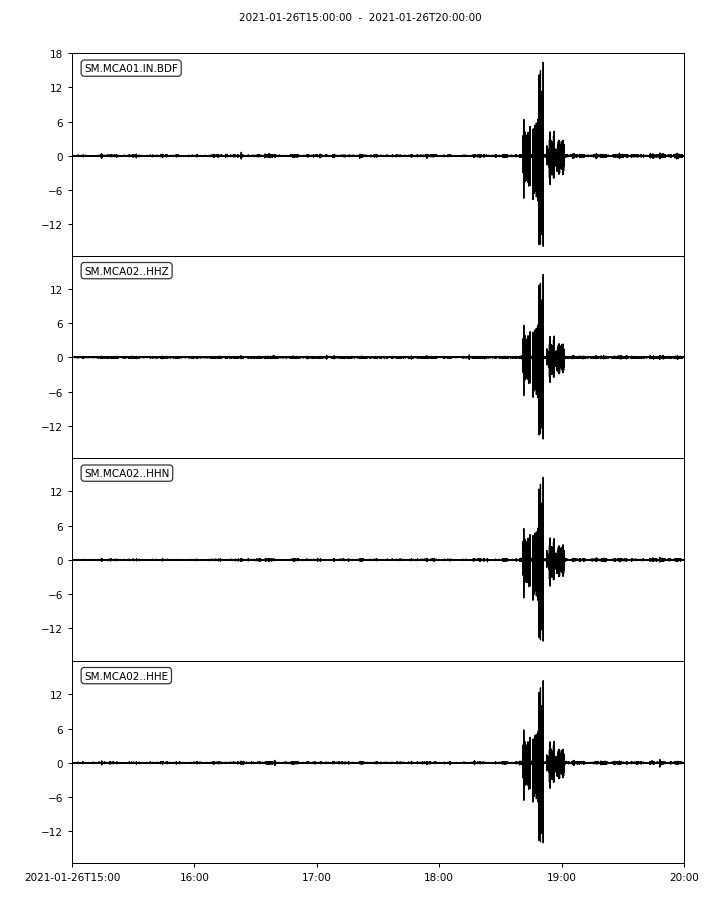

<IPython.core.display.Javascript object>


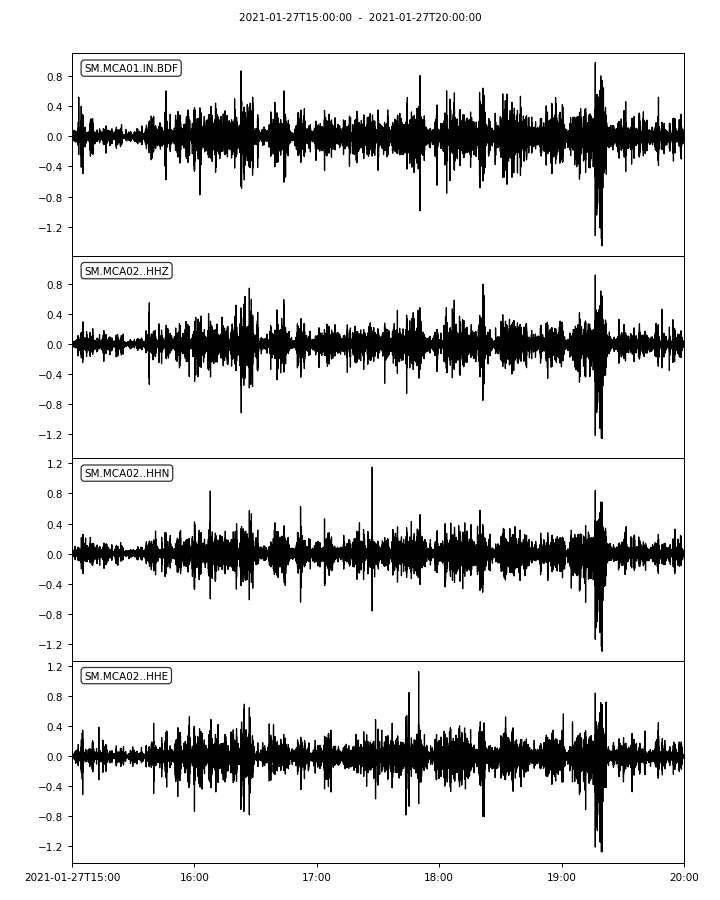

<IPython.core.display.Javascript object>


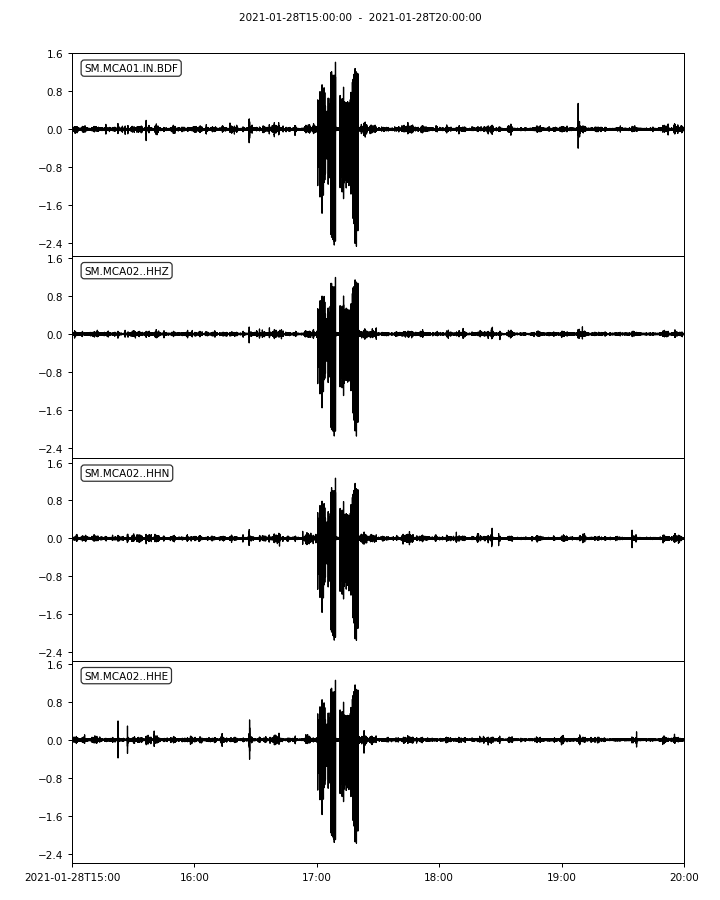

<IPython.core.display.Javascript object>


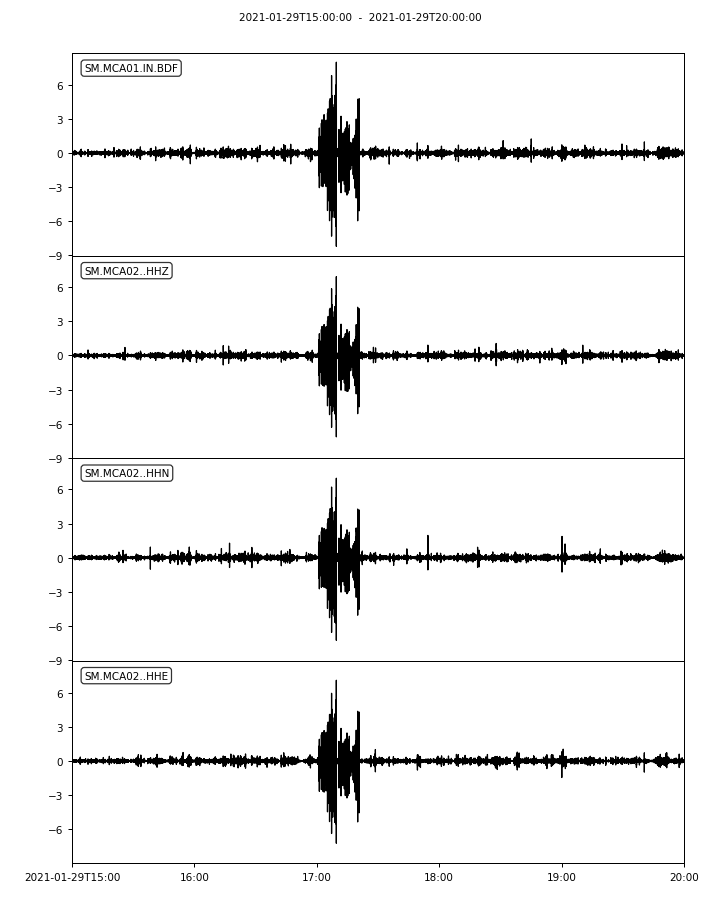

<IPython.core.display.Javascript object>


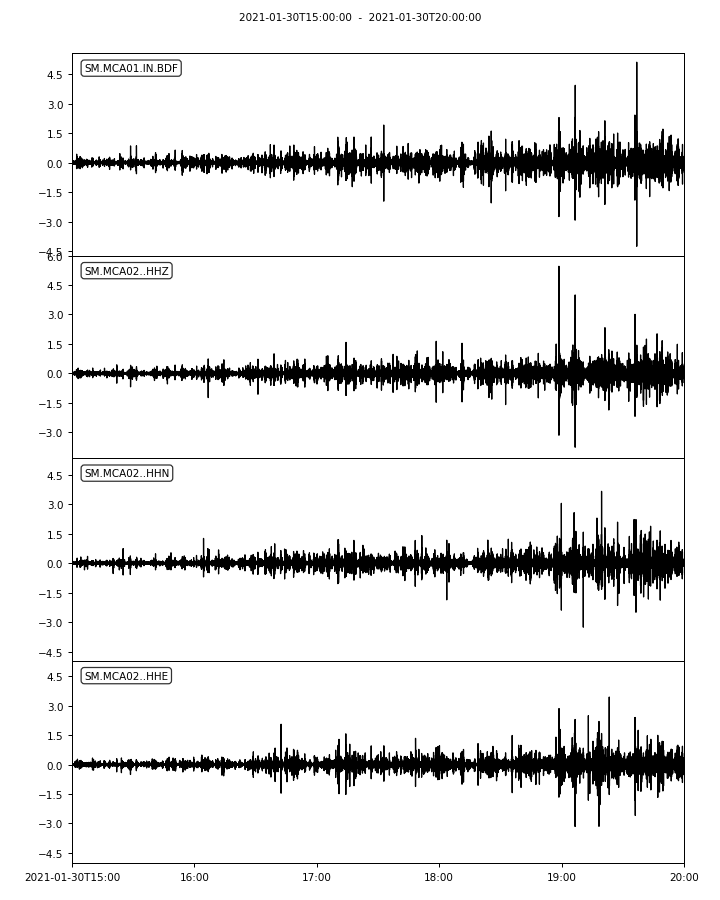

<IPython.core.display.Javascript object>


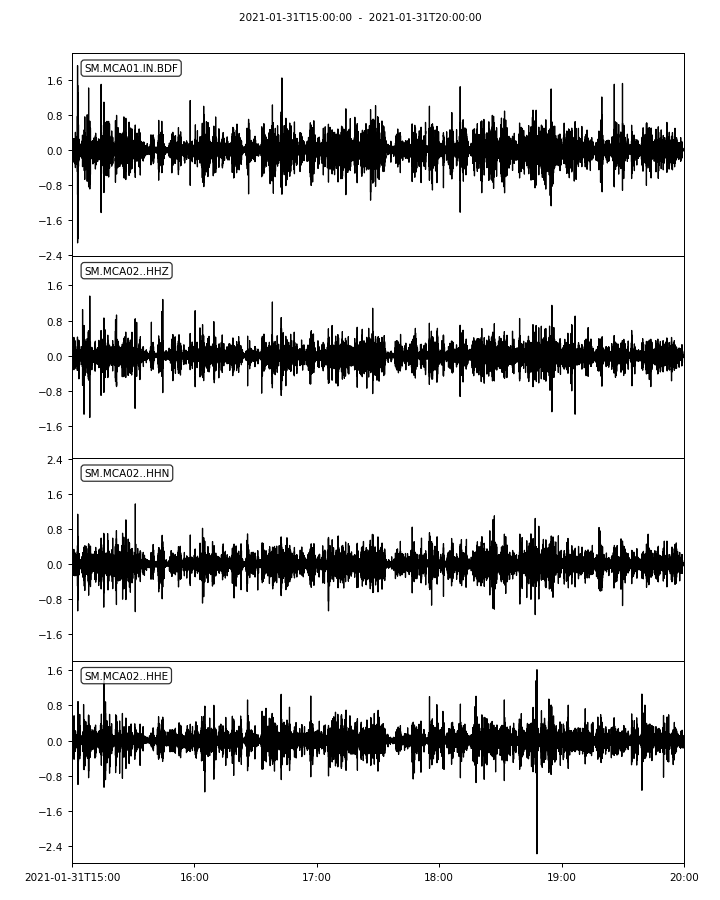

<IPython.core.display.Javascript object>


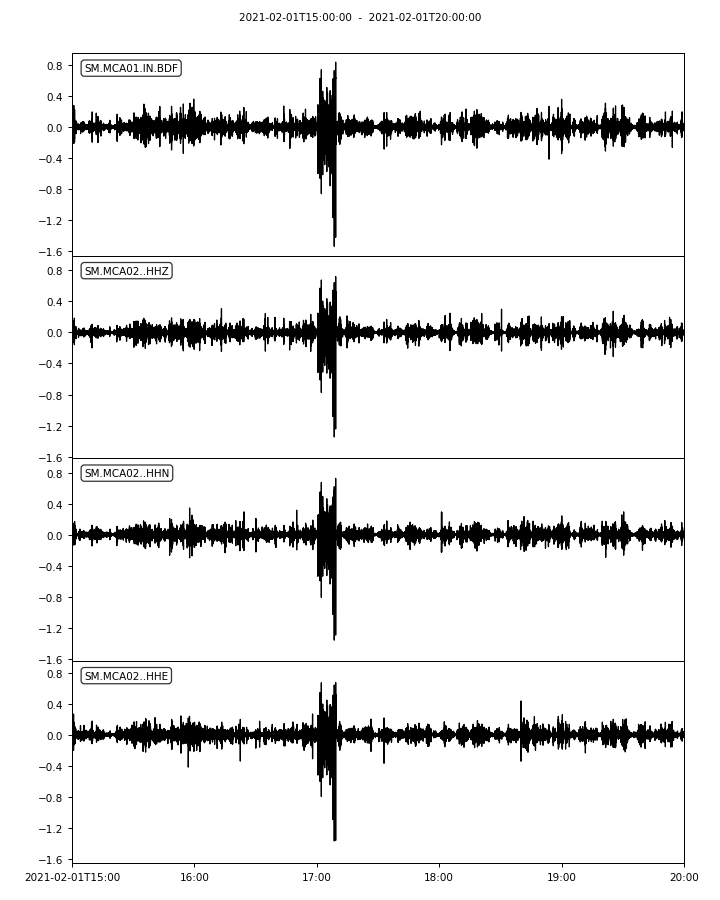

<IPython.core.display.Javascript object>


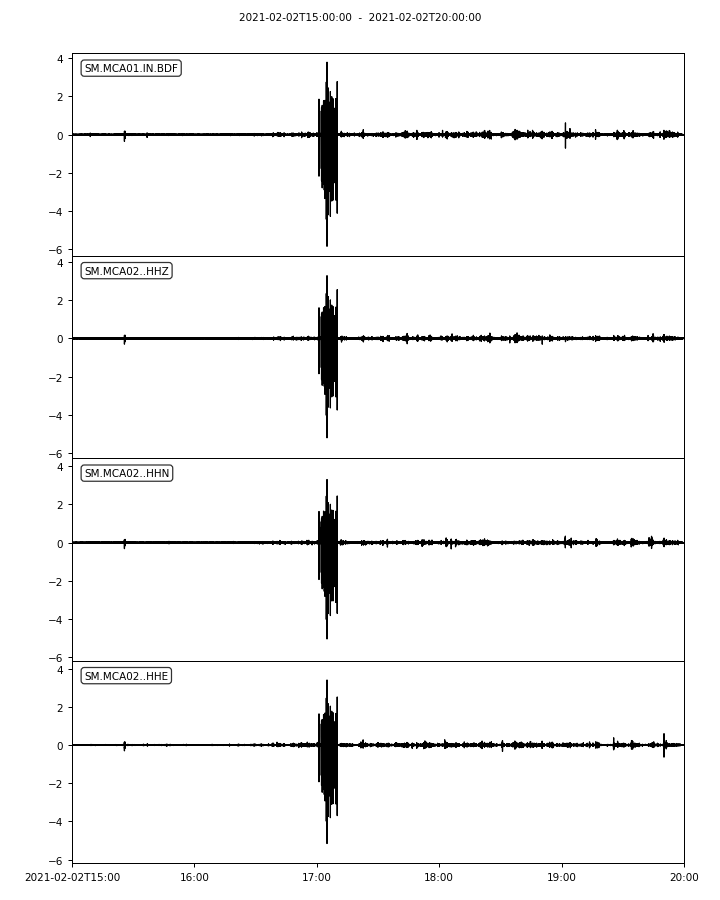

<IPython.core.display.Javascript object>


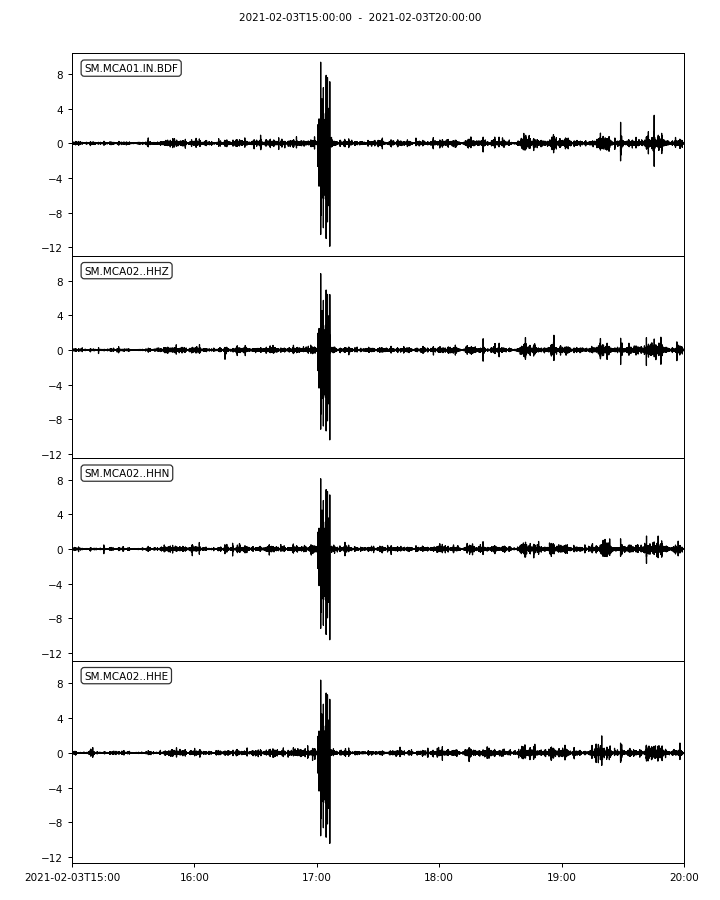

<IPython.core.display.Javascript object>


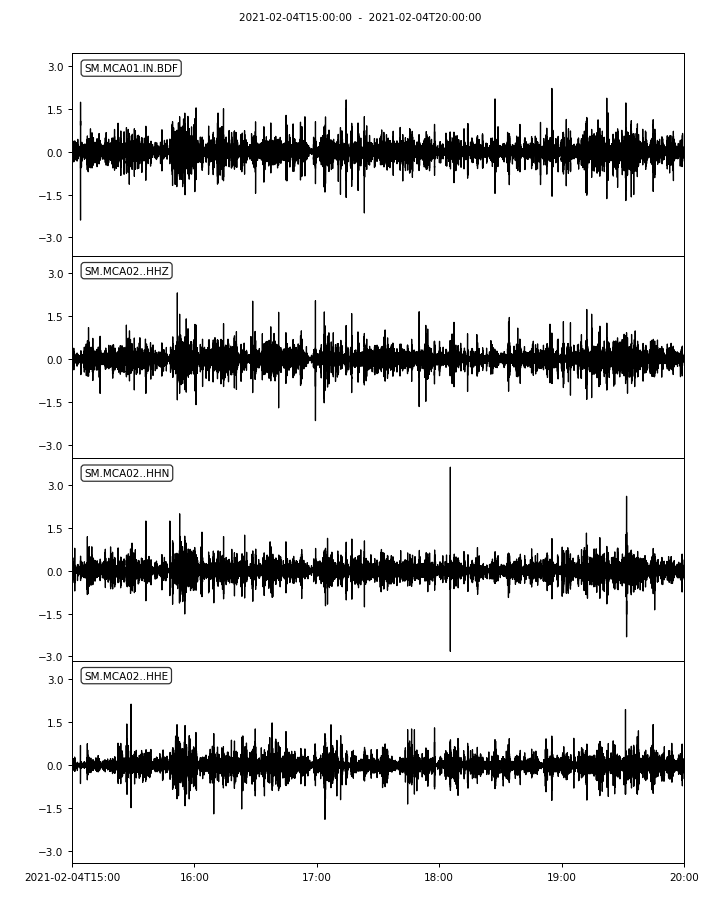

<IPython.core.display.Javascript object>


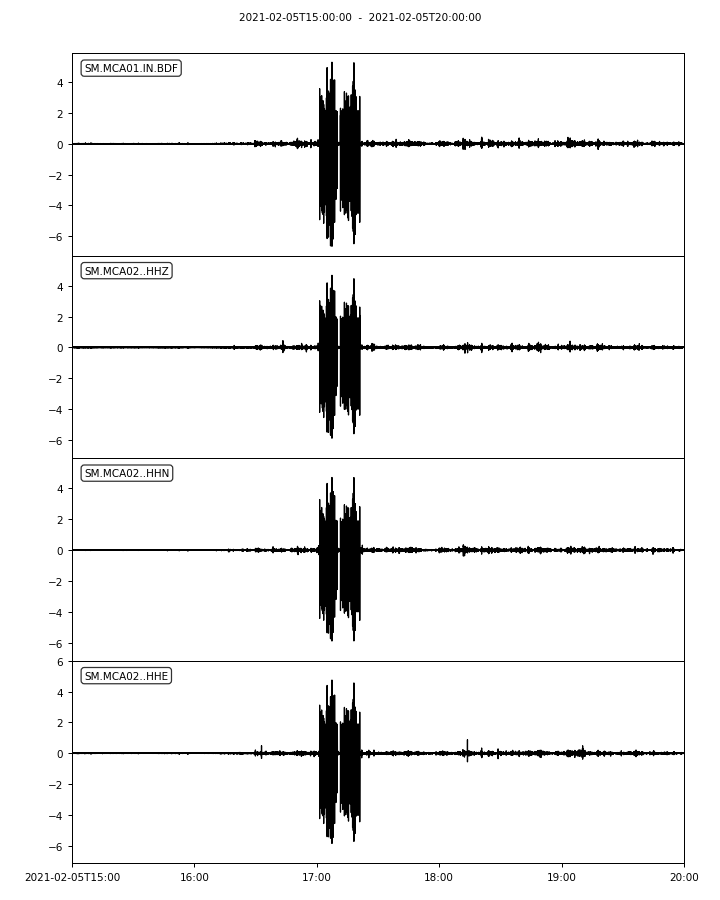

<IPython.core.display.Javascript object>


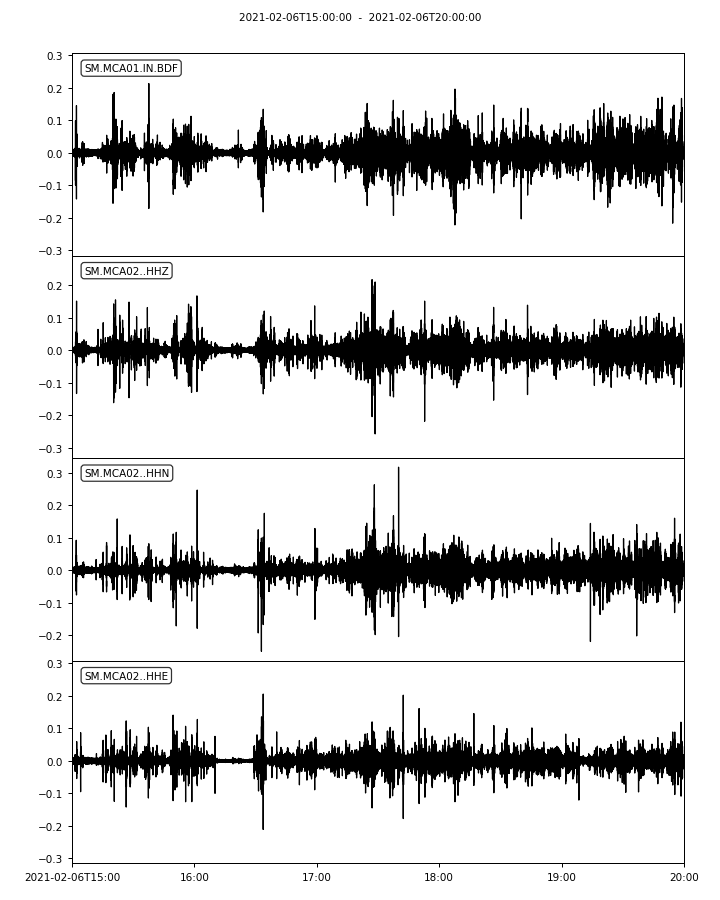

<IPython.core.display.Javascript object>


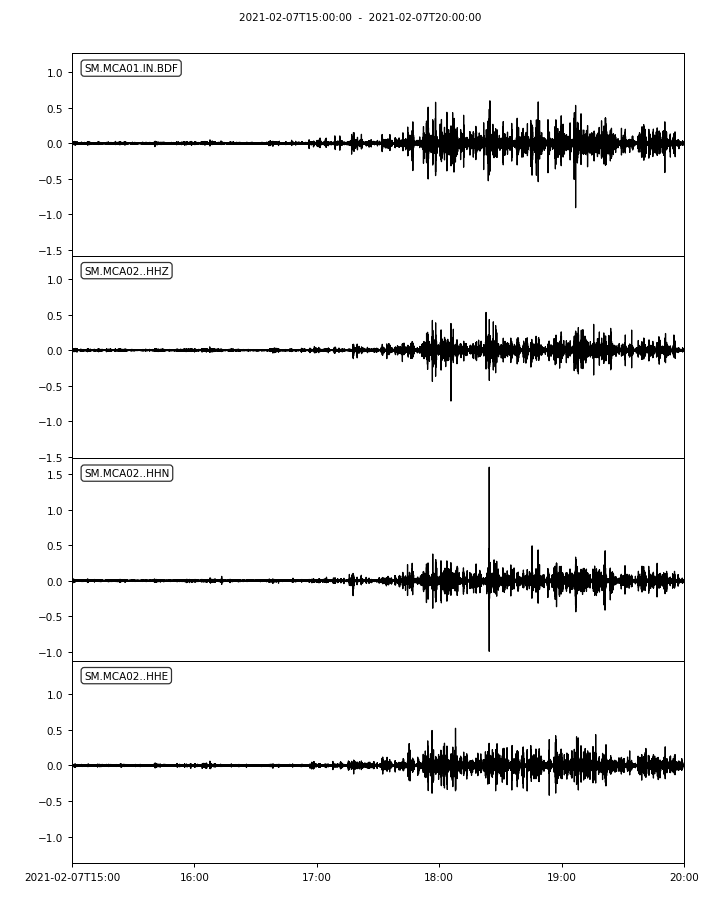

<IPython.core.display.Javascript object>


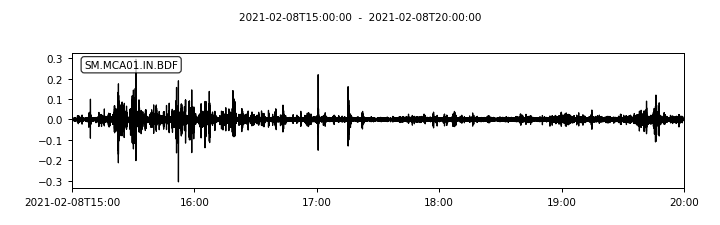

<IPython.core.display.Javascript object>


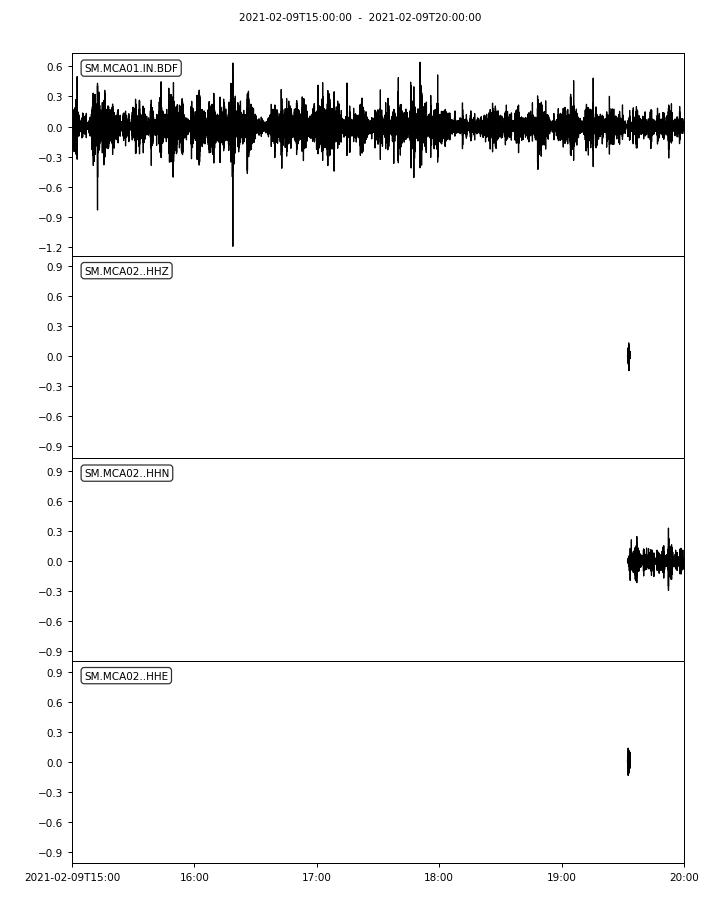

<IPython.core.display.Javascript object>


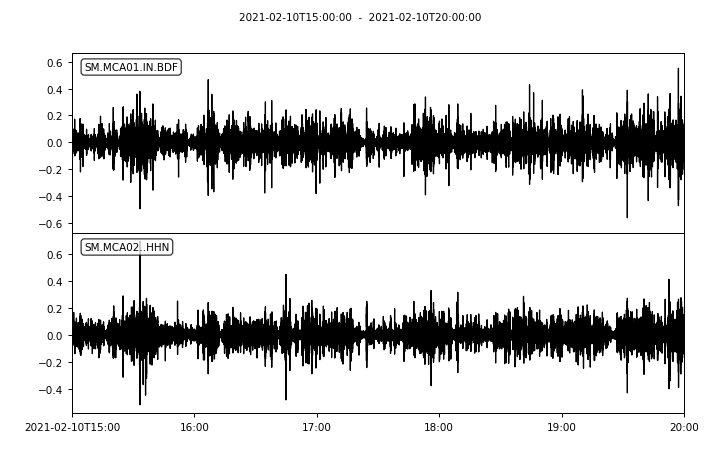

<IPython.core.display.Javascript object>


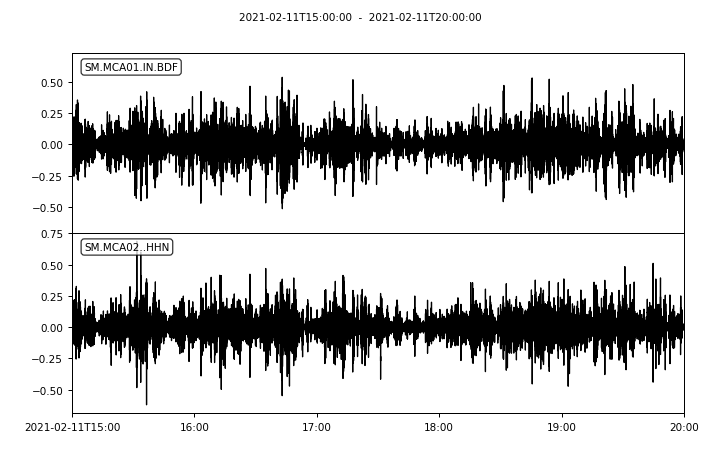

<IPython.core.display.Javascript object>


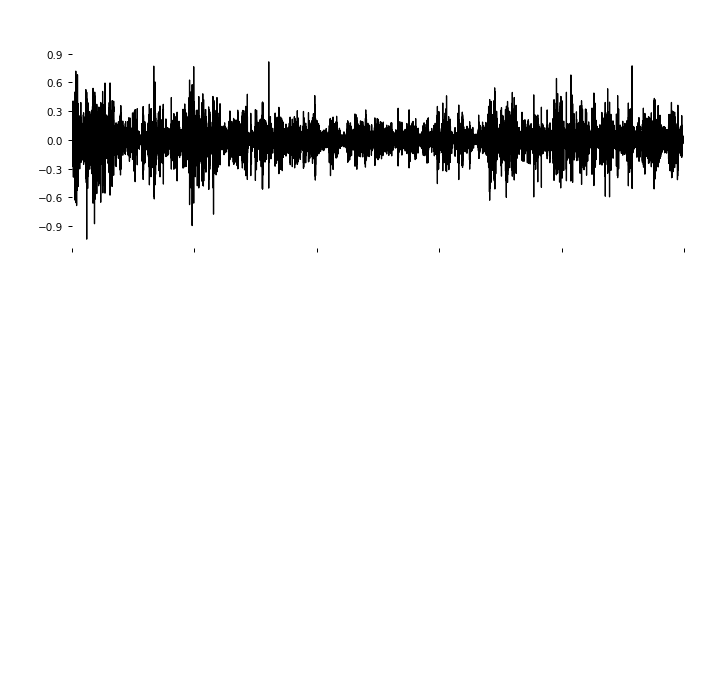

<IPython.core.display.Javascript object>


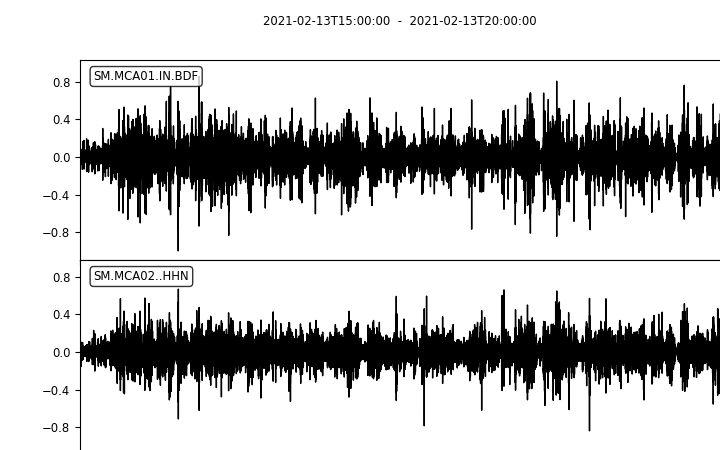

<IPython.core.display.Javascript object>


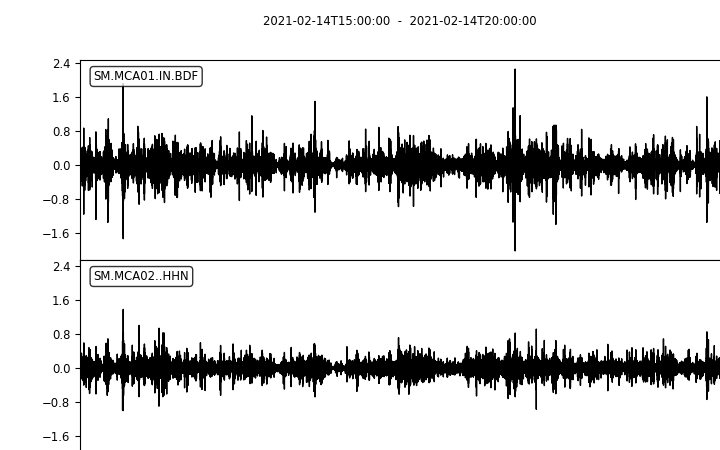

<IPython.core.display.Javascript object>


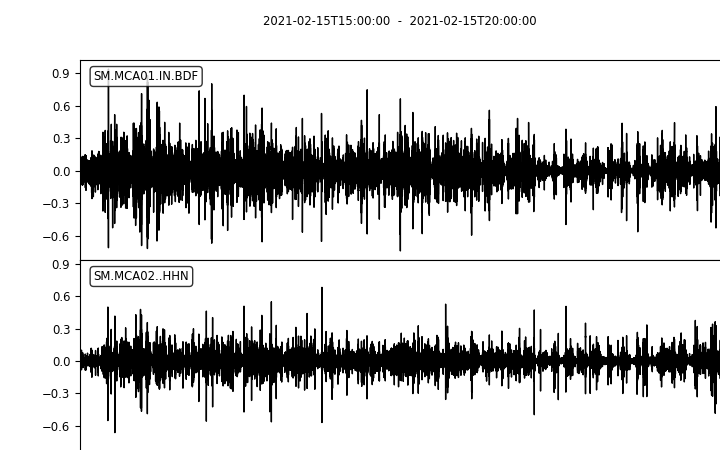

<IPython.core.display.Javascript object>


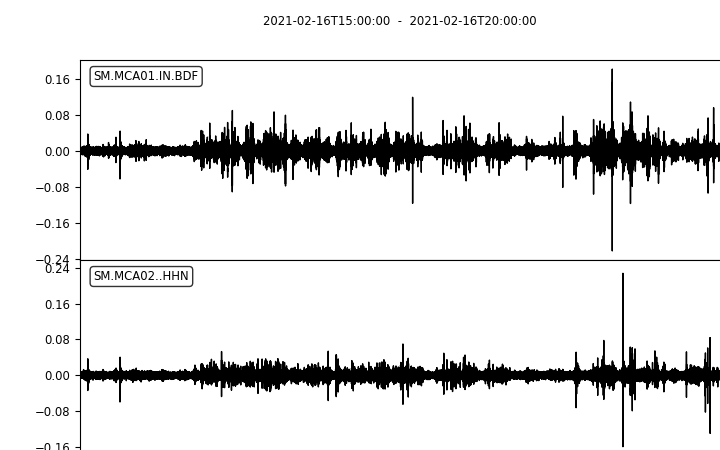

<IPython.core.display.Javascript object>


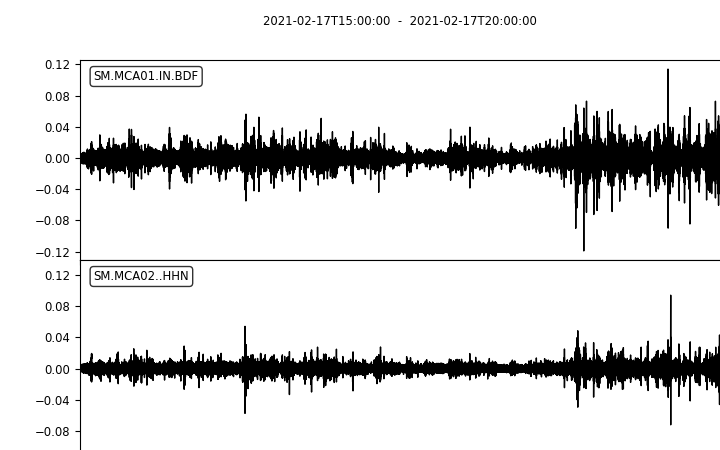

<IPython.core.display.Javascript object>


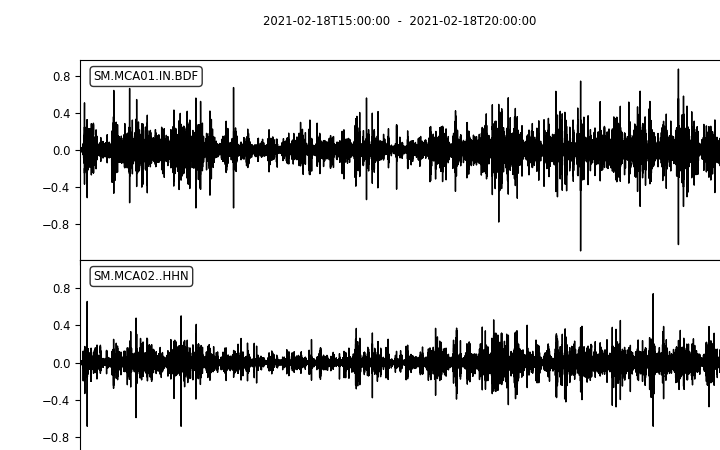

<IPython.core.display.Javascript object>


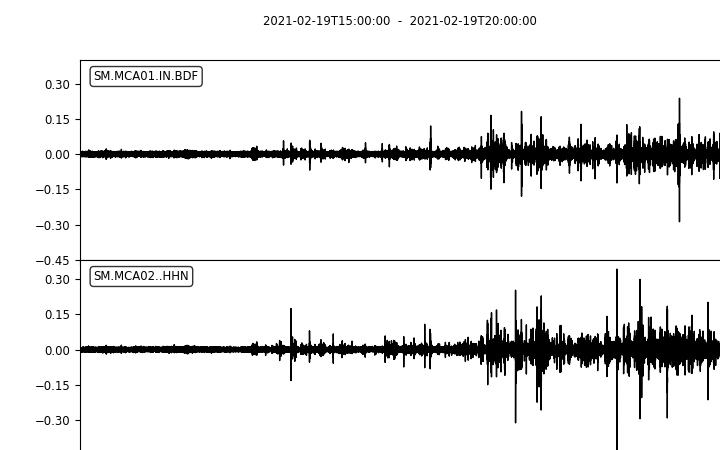

<IPython.core.display.Javascript object>


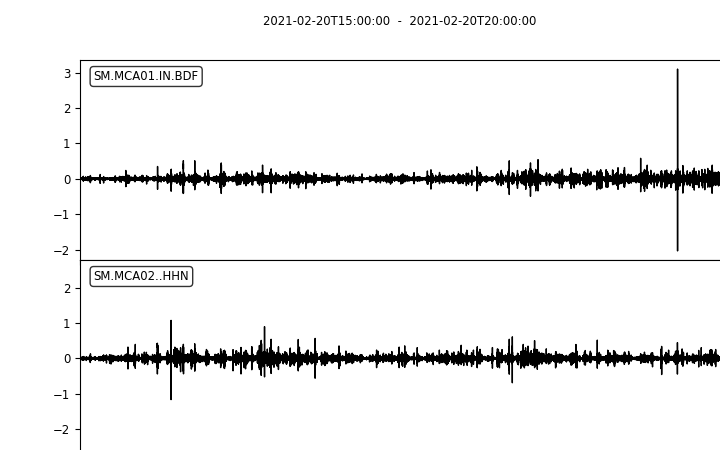

<IPython.core.display.Javascript object>


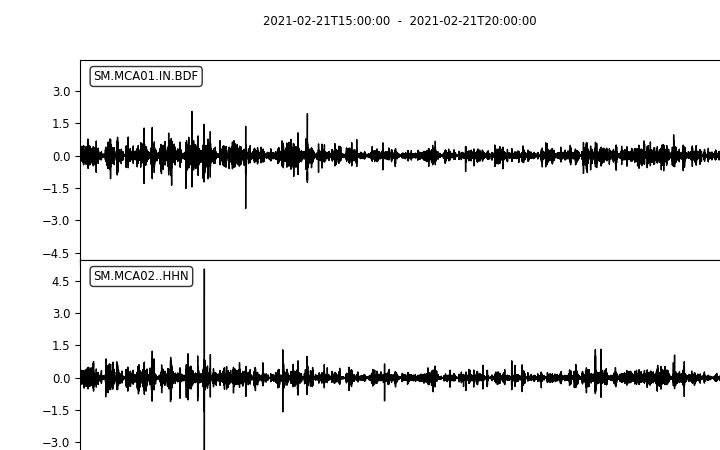

<IPython.core.display.Javascript object>


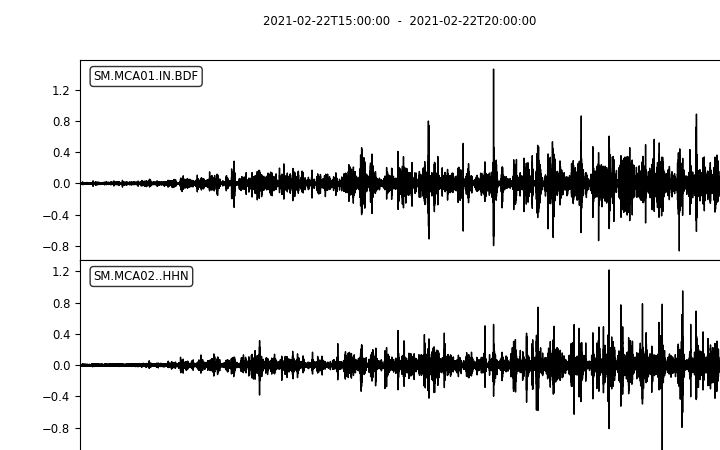

<IPython.core.display.Javascript object>


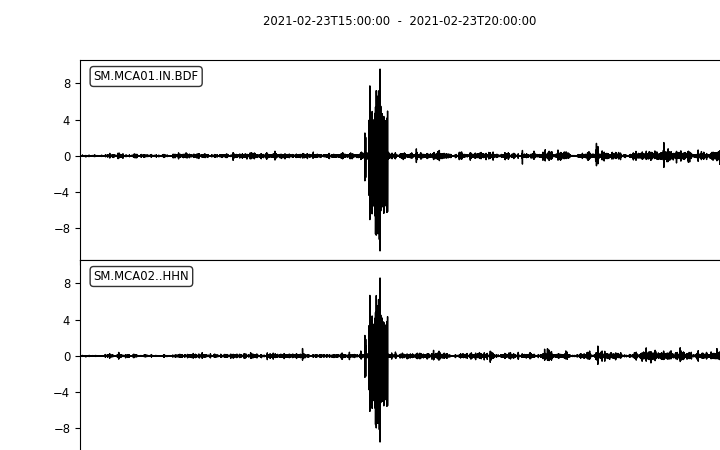

<IPython.core.display.Javascript object>


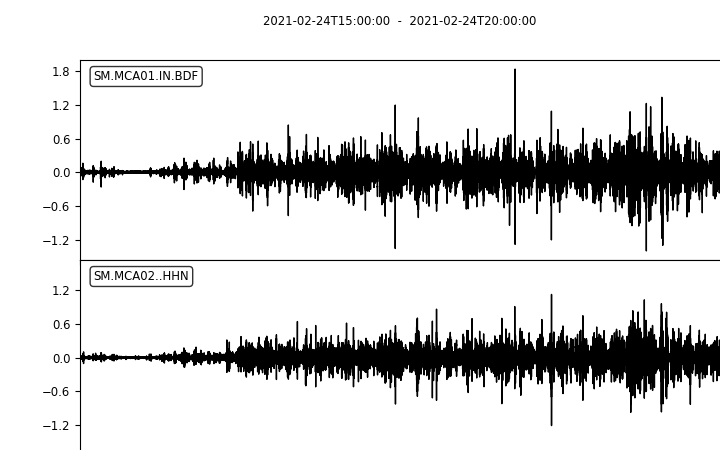

<IPython.core.display.Javascript object>


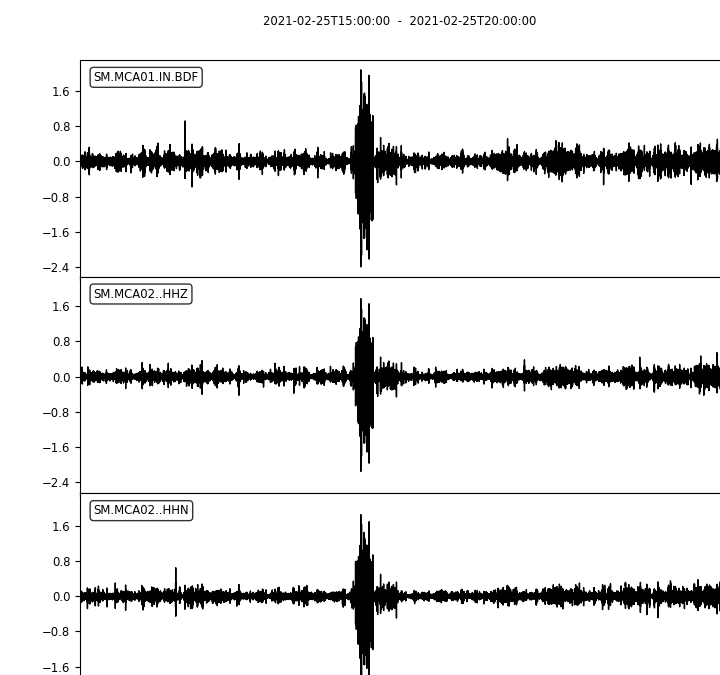

<IPython.core.display.Javascript object>


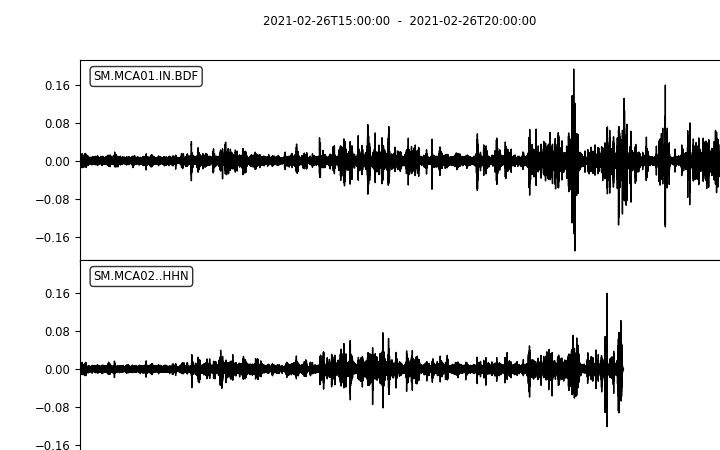

<IPython.core.display.Javascript object>


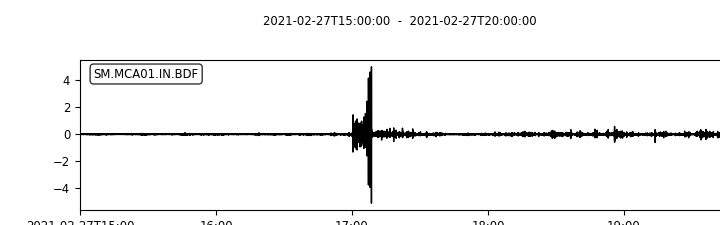

<IPython.core.display.Javascript object>


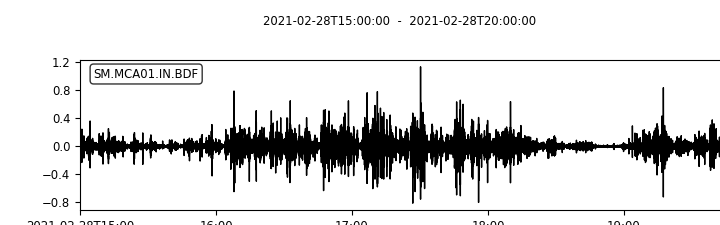

<IPython.core.display.Javascript object>


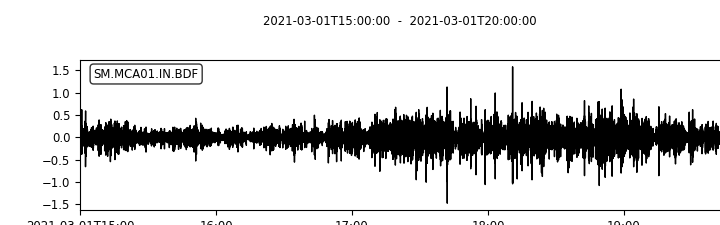

<IPython.core.display.Javascript object>


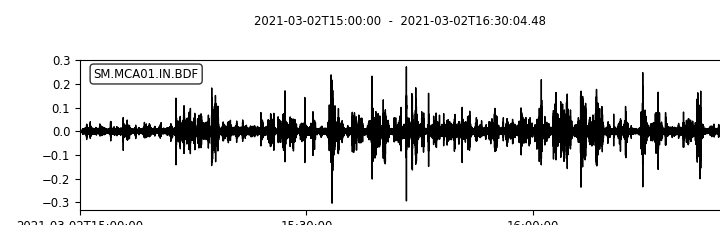

In [2]:
%matplotlib notebook
julian_days = np.arange(11,62,1) # this was to run through everything and check for detections
for day in julian_days:
    # Trim stream - detonations occur mid-day
    if day <= 31: # January
        startTime = UTCDateTime('2021-01-'+str(day)+'T15:00:00')
        endTime = UTCDateTime('2021-01-'+str(day)+'T20:00:00')
    elif (day > 31) and (day <= 59): # February
        day_tmp = day - 31
        startTime = UTCDateTime('2021-02-'+str(day_tmp)+'T15:00:00')
        endTime = UTCDateTime('2021-02-'+str(day_tmp)+'T20:00:00')
    elif day > 59: # March 
        day_tmp = day - 59
        startTime = UTCDateTime('2021-03-'+str(day_tmp)+'T15:00:00')
        endTime = UTCDateTime('2021-03-'+str(day_tmp)+'T20:00:00')
    #-----------------------------------------------------------------------------------------------------------------------#
    # Download data and remove instrument response
    st = mcaap.read_data(day=day, data_dir=[MCA_dir+'MCA01/BDF*/', MCA_dir+'MCA02/HH*/'], loc_dir=MCA_dir+'MCA_BDF_Locations.txt', MCA=True)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Filter trimmed stream to help determine start time
    st.trim(startTime, endTime)
    st_filt = st.copy()
    st_filt.taper(type='cosine', max_percentage=0.05, max_length=60)
    try:
        st_filt.filter('bandpass', freqmin=1, freqmax=10)
    except:
        st_filt = st_filt.split()
        st_filt.filter('bandpass', freqmin=1, freqmax=10)
        st_filt.merge()
    #-----------------------------------------------------------------------------------------------------------------------#
    # Plot filtered stream and save
    st_filt.plot(handle=True, method='full', type='normal', equal_scale=True);

Dates were determined after analyzing array streams and corroborating with GT logs. There was one day with anomalously low SNR which was omitted. Evident wind gusts during days where no detections were observed but shots were detonated.

In [2]:
date_format = '%Y/%m/%d'
dets_dates = ['2021/01/11','2021/01/12','2021/01/13','2021/01/20','2021/01/23',
              '2021/01/26','2021/01/27','2021/01/28','2021/01/29','2021/02/01',
              '2021/02/02','2021/02/03','2021/02/05','2021/02/23','2021/02/25',
              '2021/02/27']
dets_start = ['17:00:00','17:00:00','17:10:00','17:00:00','17:00:00',
              '18:35:00','19:00:00','17:00:00','17:00:00','17:00:00',
              '17:00:00','17:00:00','17:00:00','17:00:00','17:00:00',
              '17:00:00']
dets_end = ['17:30:00','17:30:00','17:30:00','17:30:00','17:15:00',
            '19:05:00','19:30:00','17:30:00','17:30:00','17:15:00',
            '17:15:00','17:15:00','17:30:00','17:20:00','17:30:00',
            '17:15:00']

---
#### Further trimming streams (keep in mind that writing as mseed does not save location info)

In [3]:
%%time
# Further trimming and saving detections
dets_julian_days = []
for date, start, end in zip(dets_dates, dets_start, dets_end):
    st = Stream()
    # Trim stream - detonations occur mid-day
    startTime = UTCDateTime(date.replace('/','-') + 'T' + start)
    endTime = UTCDateTime(date.replace('/','-') + 'T' + end) 
    day = mcaap.YMD_to_JD(date_format, date)[0]; dets_julian_days.append(day)
    # Save start times
    with open(MCA_dir+'MCA_Detections/Signal_Times_CWT/UTC_Starttimes/'+str(day)+'.txt', 'w') as file:
        file.write(str(startTime))
    #-----------------------------------------------------------------------------------------------------------------------#
    # Download data and remove instrument response
    st = mcaap.read_data(day=day, data_dir=[MCA_dir+'MCA01/BDF*/', MCA_dir+'MCA02/HH*/'], loc_dir=MCA_dir+'MCA_BDF_Locations.txt', MCA=True)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Trim stream and save
    st.trim(startTime, endTime)
    try:
        st.write(MCA_dir+'MCA_Detections/Data/MCA_'+str(day)+'.mseed', format='MSEED')
    except:
        st = st.split().copy()
        st.write(MCA_dir+'MCA_Detections/Data/MCA_'+str(day)+'.mseed', format='MSEED')

CPU times: user 3.06 s, sys: 1.41 s, total: 4.46 s
Wall time: 6.95 s


## Blast Sequence Segmentation
---
#### Extracting times of signal peaks using CWT (find_peaks_cwt) to be used for time window construction

Peaks saved for MCA01 - BDF
Figure saved
Peaks saved for MCA02 - HHZ
Figure saved
Peaks saved for MCA02 - HHE
Figure saved
Peaks saved for MCA02 - HHN
Figure saved
CPU times: user 2min 1s, sys: 3.25 s, total: 2min 5s
Wall time: 2min 2s


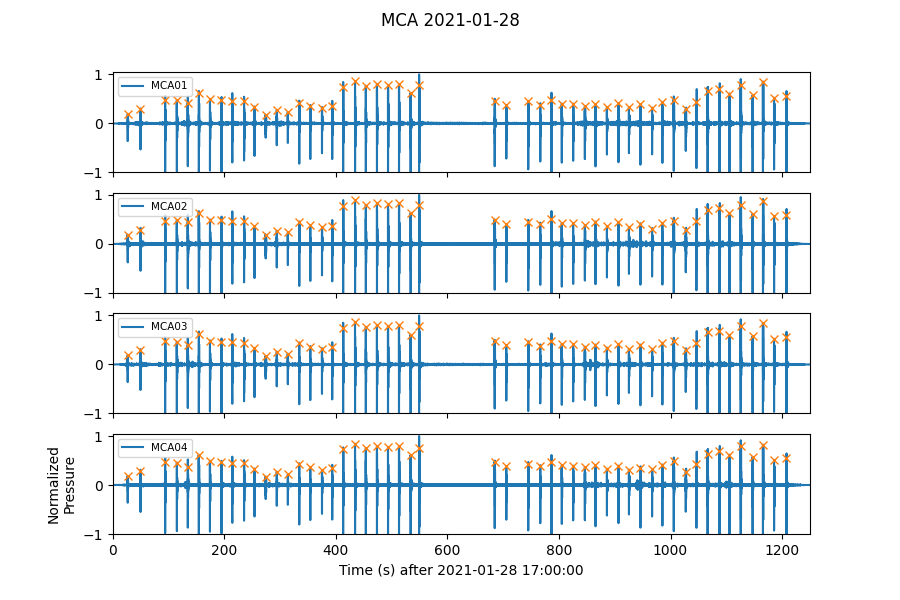

In [4]:
%%time
mcaap.get_signal_times_cwt(day_idx=7, dets_julian_days=dets_julian_days, trim_from_start=None, trim_from_end=550, legend_loc='upper left', legend_size=7.5, MCA=True,
                           scales=[0.1,0.2,0.3,0.4,0.5], min_snr=10, min_distance_secs=15, find_peaks=True, save=True)

Making widths 10x larger resulted in fewer correct peak detections

The cwt works very well for signals with low amplitudes that don't pass the vertical threshold.

---
#### Extracting times using Cardinal

In [5]:
# Constructing frequency bands for Cardinal
f_bands = cardinal.make_custom_fbands(f_min=0.1, f_max=55, win_max=120, type='third_octave')
f_bands['fmax'].values[-1] = np.round(f_bands['fmax'].values[-1],0) - 1 # rounding so f_max becomes Nyquist
f_bands

band       fmin    fcenter       fmax         win       step
0    1.0   0.100000   0.112996   0.125992  106.518929  10.651893
1    2.0   0.125992   0.142366   0.158740   85.119063   8.511906
2    3.0   0.158740   0.179370   0.200000   68.133978   6.813398
3    4.0   0.200000   0.225992   0.251984   54.652907   5.465291
4    5.0   0.251984   0.284732   0.317480   43.952974   4.395297
5    6.0   0.317480   0.358740   0.400000   35.460432   3.546043
6    7.0   0.400000   0.451984   0.503968   28.719896   2.871990
7    8.0   0.503968   0.569464   0.634960   23.369930   2.336993
8    9.0   0.634960   0.717480   0.800000   19.123658   1.912366
9   10.0   0.800000   0.903968   1.007937   15.753391   1.575339
10  11.0   1.007937   1.138929   1.269921   13.078407   1.307841
11  12.0   1.269921   1.434960   1.600000   10.955272   1.095527
12  13.0   1.600000   1.807937   2.015874    9.270138   0.927014
13  14.0   2.015874   2.277858   2.539842    7.932646   0.793265
14  15.0   2.539842   2.869921   3.200000    6.871079   0.687108
15  16.0   3.200000   3.615874   4.031747    6.028512   0.602851
16  17.0   4.031747   4.555715   5.079683    5.359766   0.535977
17  18.0   5.079683   5.739842   6.400000    4.828982   0.482898
18  19.0   6.400000   7.231747   8.063495    4.407698   0.440770
19  20.0   8.063495   9.111431  10.159367    4.073326   0.407333
20  21.0  10.159367  11.479683  12.800000    3.807934   0.380793
21  22.0  12.800000  14.463495  16.126989    3.597292   0.359729
22  23.0  16.126989  18.222861  20.318733    3.430105   0.343011
23  24.0  20.318733  22.959367  25.600000    3.297409   0.329741
24  25.0  25.600000  28.926989  32.253979    3.192089   0.319209
25  26.0  32.253979  36.445723  40.637467    3.108495   0.310850
26  27.0  40.637467  45.918733  50.000000    3.042147   0.304215

CPU times: user 9.2 s, sys: 4.95 s, total: 14.1 s
Wall time: 27.9 s


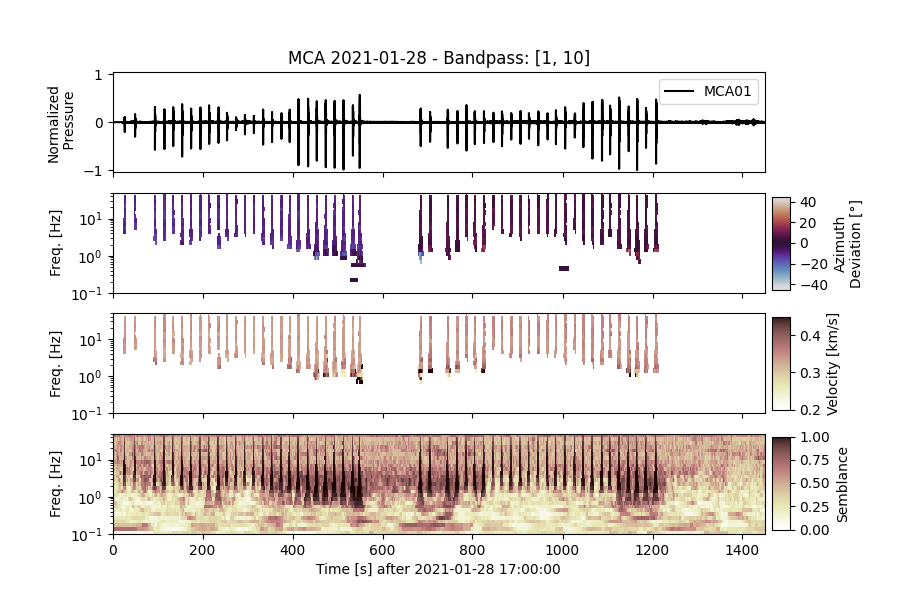

In [10]:
%%time
from dask.distributed import Client
n_workers = 4; client = Client(threads_per_worker=1, n_workers=n_workers, memory_limit='3GB')
# Further trimming and processing detections
for date, start, end in zip(dets_dates, dets_start, dets_end):
    if date == '2021/01/28':
        pass
    else:
        continue
    st = Stream()
    # Trim stream - detonations occur mid-day
    startTime = UTCDateTime(date.replace('/','-') + 'T' + start)
    endTime = UTCDateTime(date.replace('/','-') + 'T' + end) - 30 # fixes endtime problem
    day = mcaap.YMD_to_JD(date_format, date)[0]
    # Save start times
    with open(MCA_dir+'MCA_Detections/Signal_Times_Cardinal/UTC_Starttimes/'+str(day)+'.txt', 'w') as file:
        file.write(str(startTime))
    #-----------------------------------------------------------------------------------------------------------------------#
    # Download data and remove instrument response
    st = mcaap.read_data(day=day, data_dir=[MCA_dir+'MCA01/BDF*/', MCA_dir+'MCA02/HH*/'], loc_dir=MCA_dir+'MCA_BDF_Locations.txt', MCA=True)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Trim stream and save
    st.trim(startTime, endTime)
    try:
        st.write(MCA_dir+'MCA_Detections/Data/MCA_'+str(day)+'.mseed', format='MSEED')
    except:
        st = st.split().copy()
        st.write(MCA_dir+'MCA_Detections/Data/MCA_'+str(day)+'.mseed', format='MSEED')
    #-----------------------------------------------------------------------------------------------------------------------#
    # Run Cardinal
    try:
        T, B, V, S = cardinal.sliding_time_array_fk_multifreq(st, f_bands, client, signal_type="infrasound", adaptive_array=False)
    except:
        st = st.merge() # fixes starttime issue
        T, B, V, S = cardinal.sliding_time_array_fk_multifreq(st, f_bands, client, signal_type="infrasound", adaptive_array=False)
    #-----------------------------------------------------------------------------------------------------------------#
    # Creating families
    ref_time = st[0].stats.starttime.matplotlib_date
    ix, pixels_in_families, families = cardinal.make_families(T, B, V, S, f_bands, ref_time,
                                                          dist_threshold=1, min_pixels=50, sigma_t=2, sigma_f=2, sigma_b=10, p_threshold=0.1, 
                                                          family_grouping='kdtree')
    df = cardinal.df_families(ref_time, families)
    df.to_csv(MCA_dir+'MCA_Detections/Signal_Times_Cardinal/Families/'+str(day)+'.csv', index=False)
    #-----------------------------------------------------------------------------------------------------------------#
    # Plot results
    GT_baz = 226.5 # from Google Earth (back azimuth to Area 1)
    cardinal.plot_sliding_window_multifreq(st, f_bands, T, B, V, S, clim_vtr=[0.2,0.45], clim_baz=[-45,45], normalize=True, amp_units='Pressure [Pa]',
                                           bandpass=[1,10], GT_baz=GT_baz, figsize=(9,6),
                                           ix=ix, pixels_in_families=pixels_in_families,
                                           title='MCA ' + str(st[0].stats.starttime).split('T')[0], fname_plot=MCA_dir+'MCA_Detections/Signal_Times_Cardinal/Plots/'+str(day)+'.png')